In [ ]:
########################################################
# Project - GAN generate pixel art like ff6 spritesheets
#
# Target - generated image with resolution 32x32 
#
# This notebook is for education purpose only.
# 
# All input images used are found at http://finalfantasy.wikia.com/
# 
########################################################

############################################
# ***Go straight to Part 3 - GAN***
# ***if data images is already downloaded, pre-processed, and saved as x_train.pickle***
############################################

############################################
# Project folders

# data/ 
#   pickle files contain webpage hyperlinks array
#   images downloaded from website

# img/ 
#   pre-processed images, input from data/
#     by spliting large spritesheets
#     removed blank images, small character images
#   copied single character images 96x96

# gan_images/
#   generated images of current model training

# train001/ -> train00X/
#   saved version of trained model .h5 file
#   gen_images/ is generated images during model training

############################################

In [ ]:
#####################################################
# Part 1 - Get Images Online
#####################################################

#####################################################
# website structure
#   http://finalfantasy.wikia.com/

# 4 web pages, each page got over hundred links to indivdual web page for each spritesheet 
# for each spritesheet web page (there are total of hundreds), contains one image link

# each page link - example
# http://finalfantasy.wikia.com/wiki/File:FFRK_AC_Cloud.png

# each image page contains one a link, html soup analysis
# <div class="fullImageLink" id="file"><a href="https://vignette.wikia.nocookie.net/finalfantasy/images/5/53/FFRK_AC_Cloud.png/revision/latest?cb=20150930085325"><img alt="File:FFRK AC Cloud.png" src="https://vignette.wikia.nocookie.net/finalfantasy/images/5/53/FFRK_AC_Cloud.png/revision/latest?cb=20150930085325" data-image-name="FFRK AC Cloud.png" data-image-key="FFRK_AC_Cloud.png" data-src="https://vignette.wikia.nocookie.net/finalfantasy/images/5/53/FFRK_AC_Cloud.png/revision/latest?cb=20150930085325" class="lzyPlcHld lzyTrns lzyLoaded" onload="if(typeof ImgLzy==='object'){ImgLzy.load(this)}" width="96" height="96"><noscript><img alt="File:FFRK AC Cloud.png" src="https://vignette.wikia.nocookie.net/finalfantasy/images/5/53/FFRK_AC_Cloud.png/revision/latest?cb=20150930085325" width="96" height="96" data-image-name="FFRK AC Cloud.png" data-image-key="FFRK_AC_Cloud.png" /></noscript></a><div class="mw-filepage-resolutioninfo">No higher resolution available.</div></div>
#####################################################

In [1]:
# packages
import bs4 as bs
import pickle
import requests

import numpy as np
import os
import time

from tqdm import tnrange, tqdm_notebook

In [2]:
data_folder = 'data'
img_folder = 'img'
domain = 'http://finalfantasy.wikia.com/'

In [8]:
# get all image a links from html page
def save_img_links(i, page_link):

    #create folder data if not exist
    if not os.path.exists(data_folder):
        os.makedirs(data_folder)
        
    save_path = "%s/ff6pages%d.pickle" % (data_folder, i)
    
    # do not get links if already retrieved
    if os.path.exists(save_path):
        print ('%s already exist.' % (save_path))
        return
    
    resp = requests.get(page_link)
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    div = soup.find('div', {'class': 'category-page__members'})

    img_links = []
    for a_tag in div.findAll('a'):
        a_link = a_tag['href']
        img_links.append(a_link)
        # print (a_link)
        
    
    with open(save_path,"wb") as f:
        pickle.dump(img_links, f)
       
    print ('Saved page image links to pickle - %s' % page_link)
    
    return img_links
    
# html soup analysis
# soup.find('div', {'class': 'category-page__members'})
# soup.find('a', {'class': 'category-page__member-link'})

In [10]:
# run to get page html a links
def get_page_links():
    
    page_links = []

    # 4 pages of spritesheets
    page_links.append(domain+'wiki/Category:Final_Fantasy_Record_Keeper_Sprite_Images')
    page_links.append(domain+'wiki/Category:Final_Fantasy_Record_Keeper_Sprite_Images?from=FFRK+Gladiator+sprites.png')
    page_links.append(domain+'wiki/Category:Final_Fantasy_Record_Keeper_Sprite_Images?from=FFRK+Reynn.png')
    page_links.append(domain+'wiki/Category:Final_Fantasy_Record_Keeper_Sprite_Images?from=FFRK+Ysayle.png')

    return page_links

def run_save_img_links():
    
    page_links = get_page_links()
    for i, page_link in enumerate(page_links):
        save_img_links(i, page_link)

run_save_img_links()

Saved page image links to pickle - http://finalfantasy.wikia.com/wiki/Category:Final_Fantasy_Record_Keeper_Sprite_Images
Saved page image links to pickle - http://finalfantasy.wikia.com/wiki/Category:Final_Fantasy_Record_Keeper_Sprite_Images?from=FFRK+Gladiator+sprites.png
Saved page image links to pickle - http://finalfantasy.wikia.com/wiki/Category:Final_Fantasy_Record_Keeper_Sprite_Images?from=FFRK+Reynn.png
Saved page image links to pickle - http://finalfantasy.wikia.com/wiki/Category:Final_Fantasy_Record_Keeper_Sprite_Images?from=FFRK+Ysayle.png


In [11]:
# download images from page links
def get_images_from_a_links(reload_page=False):
    if reload_page:
        tickers = run_save_img_links()
    else:
        # load all pickle(s)
        for file in tqdm_notebook(os.listdir(data_folder)):
            if file.endswith('.pickle'):
                load_path = '%s/%s' % (data_folder, file)
            
                with open(load_path, "rb") as f:
                    image_page_links = pickle.load(f)

                    for j in tqdm_notebook(range(len(image_page_links))):
                        link = image_page_links[j]
                        image_page_link = ('%s/%s' % (domain, link))

                        resp = requests.get(image_page_link)
                        soup = bs.BeautifulSoup(resp.text, 'lxml')
                        div = soup.find('div', {'class': 'fullImageLink'})
                        
                        # get image from link embeded in page link
                        a_tag = div.find('a')
                        a_link = a_tag['href']
                        
                        file_name = os.path.basename(link)
                        file_name = file_name.replace('File:', '') # remove prefix 'File:'
                        save_file_path = '%s/%s' % (data_folder, file_name)
                        
                        # check if file already downloaded
                        if os.path.exists(save_file_path):
                            # print ('%s already exist.' % (save_file_path))
                            continue
                        
                        # print ('Downloading - %s' % (a_link))
                        
                        get_file = requests.get(a_link)
                               
                        f = open(save_file_path, 'wb')
                        # print ('Saving - %s' % (a_link))
                        f.write(get_file.content)
                                        
                        # wait for a while to avoid being block
                        time.sleep(1.0)

get_images_from_a_links()


AttributeError: 'NoneType' object has no attribute 'find'

In [12]:
# test terminal wget a single image - worked
# !wget https://vignette.wikia.nocookie.net/finalfantasy/images/5/53/FFRK_AC_Cloud.png/revision/latest?cb=20150930085325

In [13]:
#####################################################
# Part 2 - Pre-processing Images
# 2.1 preview downloaded raw mages
# 2.2 remove prefix in image names - no longer needed
# 2.3 crop/rip from big spritesheet with multi images, copy single 96x96 images
# 2.4 detect and delete blank + mini character images
# 2.5 resize all images to same dimension 32x32
# 2.6 load into one big list, save as pickle
#####################################################

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm


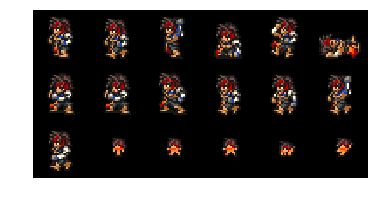

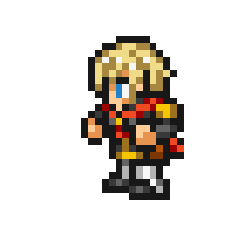

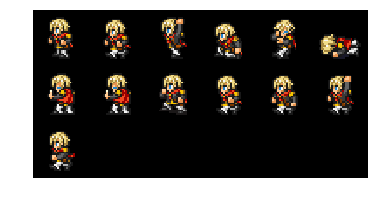

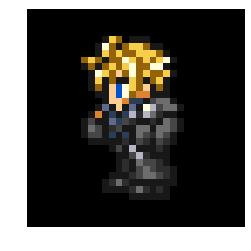

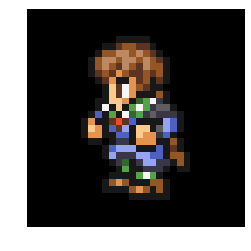

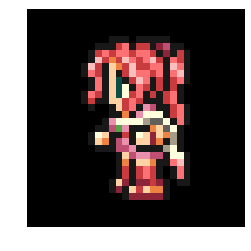

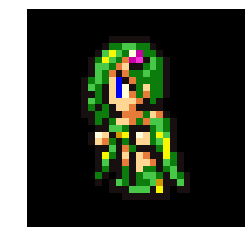

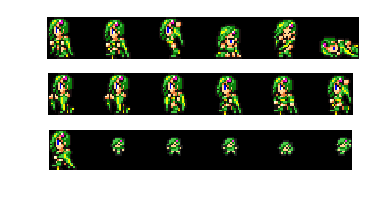

In [15]:
# 2.1 Preview downloaded raw mages
def preview_raw_data(show_count=10):
    path = os.path.join(data_folder)  

    for i, file in enumerate(os.listdir(path)):  # iterate over each image in dir
        if not file.endswith('.png'):
            continue

        # load image as color, but not in original color
        img_array = cv2.imread(os.path.join(path,file), cv2.IMREAD_COLOR)

        # convert back to original color
        img_array_RGB = cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB)

        plt.axis('off')
        plt.imshow(img_array_RGB)
        plt.show()

        if i > show_count:
            break  
            
preview_raw_data()

In [16]:
#######################
# crop / split analysis
#
# each large multi images spritesheet is 576x288, 
# it followed a foramt pattern of 6 images width by 3 images height
# width  = 576 / 6 = 96
# height = 288 / 3 = 96
# so crop large spritesheet to 6x3=18 smaller images
######################

In [17]:
# !conda install Pillow

In [18]:
# 2.2 rename all files - no longer needed
#
# remove prefix 'File:'
# e.g. 
# from File:FFRK_Devout_sprites.png
# to   FFRK_Devout_sprites.png

def rename_images():
    pattern = '*.png'
    path = data_folder
    for file in tqdm_notebook(os.listdir(path)):
        if not file.endswith('.png'):
            continue

        file_path = os.path.join(path, file)
        # print ('Renaming %s' % (file_path))

        os.rename(file_path, os.path.join(path, file.replace('File:', '')))
    
rename_images()

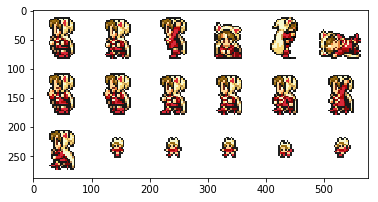

In [19]:
# 2.3 crop/rip from big spritesheet with multi images, copy single 96x96 images
from PIL import Image

# Testing - try crop one image first
img_path = 'data/FFRK_Devout_sprites.png'
img = Image.open(img_path)
plt.imshow(img)

image width is 576
image height is 288
box dimention is (0, 0, 96, 96)
<class 'PIL.Image.Image'>


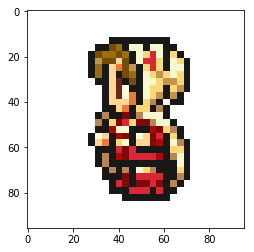

In [20]:
crop_area_width = 96
crop_area_height = 96

img_width, img_height = img.size

print ('image width is %d' % (img_width))
print ('image height is %d' % (img_height))

start_x = 0
start_y = 0
box = (start_x, start_y, start_x+crop_area_width, start_y+crop_area_height)

print('box dimention is %s' % (str(box)))

# not saved yet, in memory only
img_crop = img.crop(box)
print (type(img_crop))
plt.imshow(img_crop)


In [29]:
# crop all images in one large sprite sheet
crop_area_width = 96
crop_area_height = 96

img_width, img_height = img.size

def split_n_save_one_large_spritesheet(img_crop_path):

    crop_count = 0 # start on 1 in code below, not 0

    for h in range(0, img_height, crop_area_height): # ↓ second
        for w in range(0, img_width, crop_area_width): # → first
            start_x = w
            start_y = h
            box = (start_x, start_y, start_x+crop_area_width, start_y+crop_area_height)
            # print('box dimention is %s' % (str(box)))

            img = Image.open(img_crop_path)
            
            img_crop = img.crop(box)
            # plt.imshow(img_crop)
            # plt.show()

            filename = os.path.basename(img_crop_path)
            # e.g. 'data/FFRK_Devout_sprites.png'
            
            path_no_ext, ext = os.path.splitext(img_crop_path)
            # e.g. data/FFRK_Devout_sprites
            # e.g. .png

            save_no_ext = path_no_ext.replace('data/', '%s/'%img_folder)
            # e.g. img/FFRK_Devout_sprites

            crop_count += 1 # start on 1, not 0

            if (crop_count < 10):
                str_crop_count = '0%d' % crop_count
            else:
                str_crop_count = '%d' % crop_count

            img_crop_filename = os.path.join('%s%s%s'%(save_no_ext, str_crop_count, ext))

            if os.path.exists(img_crop_filename):
                # print ('%s already exist.' % (img_crop_filename))
                continue

            # print ('Saving image %s' % (img_crop_filename))

            img_crop.save(img_crop_filename)
            
    # print ('Saved spritesheet cropped images on %s' % (img_crop_path))
            

In [30]:
# test run
# img_path = 'data/FFRK_Devout_sprites.png'
# split_n_save_one_large_spritesheet(img_path)

In [31]:
# crop all large sprite sheet into smaller 96x96 images

input_path = data_folder
output_path = img_folder

def crop_all_large_spritesheets(sprite_sheet_width=576, sprite_sheet_height=288):   
    
    #create folders if not exist
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    for file in tqdm_notebook(os.listdir(input_path)):
        if not file.endswith('.png'):
            continue

        # check size
        img_path = os.path.join(input_path, file)
        img = Image.open(img_path)
        img_width, img_height = img.size

        if img_width == sprite_sheet_width and img_height == sprite_sheet_height:
#             print (img_path)
            split_n_save_one_large_spritesheet(img_path)
    
    print ('Saved spritesheet cropped images on %s' % (output_path))


In [32]:
# crop sprite sheet of size w=576 x h=288
crop_all_large_spritesheets()

Saved spritesheet cropped images on img


In [33]:
# crop sprite sheet of size w=480 x h=96
crop_all_large_spritesheets(480, 96)
# result 16 images

Saved spritesheet cropped images on img


In [34]:
# copy any single 96x96 images from data folder to img folder
from shutil import copyfile

copy_from_path = data_folder
copy_to_path = img_folder

def copy_single_sprites(sprite_sheet_width=96, sprite_sheet_height=96):    
    for file in tqdm_notebook(os.listdir(copy_from_path)):
        if not file.endswith('.png'):
            continue
            
        # check size
        copy_img_from_path = os.path.join(copy_from_path, file)
        copy_img_to_path = os.path.join(copy_to_path, file)
        img = Image.open(copy_img_from_path)
        img_width, img_height = img.size

        if img_width == sprite_sheet_width and img_height == sprite_sheet_height:
            copyfile(copy_img_from_path, copy_img_to_path)


In [35]:
copy_single_sprites(96, 96)

# there will be duplicates 
# as some single image sprite 96x96 already included inside larger sprite sheets 576x288

In [36]:
# result analysis
# there are 272 large spitesheets 576x288, each with 18 smaller images 96x96 inside
# result is 4896 cropped images, all images size are 96x96

# also 4 larger spritesheets 480x96 = 5 smaller images in each spritesheet =result 20 images

# there are some single images 96x96 downloaded, not original in any large sprite sheet
# i just copied them from data folder to img folder

# there are a total of 5183 images extracted to img folder
# see if you already have enough data for the deep learning GAN model on part 3

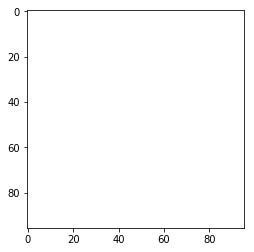

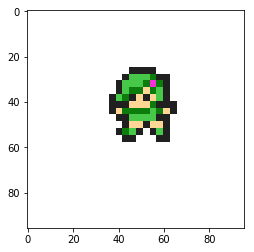

In [37]:
# 2.4 detect and delete blank + mini character images
#   there are some blank image cropped from large spritesheet empty area - to delete
#   there are mini version of the characters cropped from large spritesheet - to delete

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
from PIL import Image

# view blank image
def view_img(img_blank_path):
    img = Image.open(img_blank_path)
    plt.imshow(img)
    plt.show()
        
img_blank_path = 'img/FFRK_Ace_sprites15.png'
view_img(img_blank_path)
# file no longer exist if deleted

img_mini_character_path = 'img/FFRK_Adult_Rydia_sprites16.png'
view_img(img_mini_character_path)
# file no longer exist if deleted


In [38]:
# detect blank image, all black or all white
# Python PIL Detect if an image is completely black or white
#   https://stackoverflow.com/questions/14041562/python-pil-detect-if-an-image-is-completely-black-or-white

from PIL import ImageChops

def detect_black_img(img_path):
    img = Image.open(img_path)
    
    isblack = not img.getbbox()
    # if isblack:
    #    print ('%s - Image is all black' % (img_path))
    return isblack
            
def detect_white_img(img_path):
    img = Image.open(img_path)
    
    iswhite = not ImageChops.invert(img).getbbox()
    # if iswhite:
    #    print ('%s - Image is all white' % (img_path))
    return iswhite

def detect_empty_img(img_path):
    if detect_black_img(img_path) or detect_black_img(img_path):
        return True
    else:
        return False
    

In [39]:
# test detect an empty image
img_path = 'img/FFRK_Ace_sprites15.png'
detect_empty_img(img_path)

True

In [40]:
# test detect a normal image
img_path = 'img/FFRK_Ace_sprites10.png'
detect_empty_img(img_path)

False

In [41]:
# test delete an image

img_path = 'img/FFRK_Ace_sprites11.png'
print ('before delete %s - file exist = %s' % (img_path, os.path.exists(img_path)))

os.remove(img_path)
print ('after delete %s - file exist = %s' % (img_path, os.path.exists(img_path)))


before delete img/FFRK_Ace_sprites11.png - file exist = True
after delete img/FFRK_Ace_sprites11.png - file exist = False


In [42]:
# delete all blank images
def delete_all_blank_img(img_path):    
    for file in tqdm_notebook(os.listdir(img_path)):
        if not file.endswith('.png'):
            continue
            
        next_img_from_path = os.path.join(img_path, file)
        if detect_empty_img(next_img_from_path):
            # print ('Deleting image %s' % (next_img_from_path))
            os.remove(next_img_from_path)
            
    print ('Deleted all blank images in %s.' % (img_path))

In [43]:
delete_all_blank_img(img_folder)

Deleted all blank images in img.


In [44]:
# 4763 images left after deleted blank images

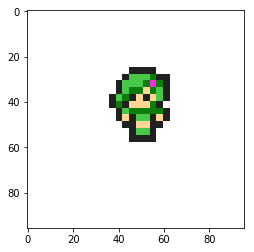

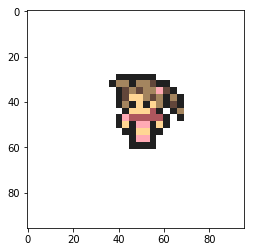

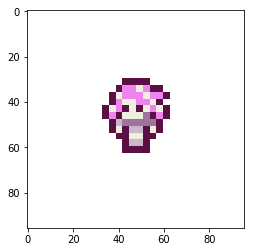

In [45]:
# Delete mini character images

# view
img_small_character_paths = []
img_small_character_paths.append('img/FFRK_Adult_Rydia_sprites14.png')
img_small_character_paths.append('img/FFRK_Adult_Rydia_sprites15.png')
img_small_character_paths.append('img/FFRK_Adult_Rydia_sprites16.png')
img_small_character_paths.append('img/FFRK_Adult_Rydia_sprites17.png')

img_small_character_paths.append('img/FFRK_Aerith_sprites14.png')
img_small_character_paths.append('img/FFRK_Aerith_sprites15.png')
img_small_character_paths.append('img/FFRK_Aerith_sprites16.png')
img_small_character_paths.append('img/FFRK_Aerith_sprites17.png')

img_small_character_paths.append('img/FFRK_Terra_Esper_sprites14.png')
img_small_character_paths.append('img/FFRK_Terra_Esper_sprites15.png')
img_small_character_paths.append('img/FFRK_Terra_Esper_sprites16.png')
img_small_character_paths.append('img/FFRK_Terra_Esper_sprites17.png')

view_img(img_small_character_paths[0])
view_img(img_small_character_paths[4])
view_img(img_small_character_paths[8])


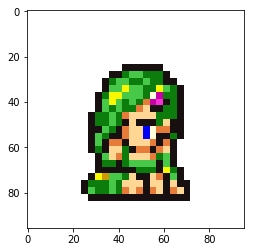

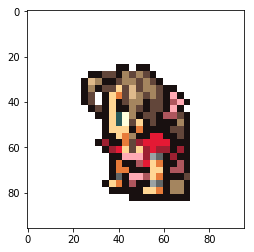

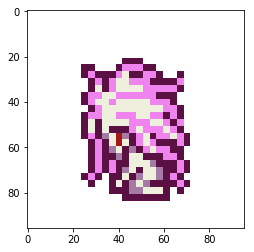

In [46]:
img_normal_character_paths = []
img_normal_character_paths.append('img/FFRK_Adult_Rydia_sprites04.png')
img_normal_character_paths.append('img/FFRK_Adult_Rydia_sprites05.png')
img_normal_character_paths.append('img/FFRK_Adult_Rydia_sprites06.png')
img_normal_character_paths.append('img/FFRK_Adult_Rydia_sprites07.png')

img_normal_character_paths.append('img/FFRK_Aerith_sprites04.png')
img_normal_character_paths.append('img/FFRK_Aerith_sprites05.png')
img_normal_character_paths.append('img/FFRK_Aerith_sprites06.png')
img_normal_character_paths.append('img/FFRK_Aerith_sprites07.png')

img_normal_character_paths.append('img/FFRK_Terra_Esper_sprites04.png')
img_normal_character_paths.append('img/FFRK_Terra_Esper_sprites05.png')
img_normal_character_paths.append('img/FFRK_Terra_Esper_sprites06.png')
img_normal_character_paths.append('img/FFRK_Terra_Esper_sprites07.png')

view_img(img_normal_character_paths[0])
view_img(img_normal_character_paths[4])
view_img(img_normal_character_paths[8])

In [47]:
import cv2
import numpy as np

def check_white_black_color_pixels(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    num_white_pixel = np.sum(img == 255)
    num_black_pixel = np.sum(img == 0)
    
    img_no_black = img[img != 0]
    img_no_white_n_black = img_no_black[img_no_black != 255]
    num_color_pixel = len(img_no_white_n_black)
    
    # print ('white pixels=%d, black pixels=%d, color pixels=%d' % (num_white_pixel, num_black_pixel, num_color_pixel))

    return (num_white_pixel, num_black_pixel, num_color_pixel)

In [48]:
# check roughly how many white pixels in small character image
for i in range(len(img_small_character_paths)):
    print (check_white_black_color_pixels(img_small_character_paths[i]))

(2592, 5958, 666)
(2592, 5886, 738)
(2592, 5886, 738)
(2592, 6021, 603)
(2592, 5877, 747)
(2592, 5805, 819)
(2592, 5805, 819)
(2592, 5994, 630)
(2304, 6210, 702)
(2304, 6156, 756)
(2304, 6156, 756)
(2304, 6273, 639)


In [49]:
# check roughly how many white pixels in norma; character image
for i in range(len(img_normal_character_paths)):
    print (check_white_black_color_pixels(img_normal_character_paths[i]))

(2304, 4599, 2313)
(2304, 4617, 2295)
(3384, 3672, 2160)
(4104, 2673, 2439)
(2304, 4707, 2205)
(2304, 4680, 2232)
(3168, 3609, 2439)
(3888, 2907, 2421)
(2304, 4464, 2448)
(2304, 4671, 2241)
(3168, 3843, 2205)
(4032, 3087, 2097)


In [50]:
# if color pixels is less than 1000, assume it is a mini character image
# delete if less than 1000, captured most mini character images, but not all

def delete_all_mini_character_img(img_path): 
    
    min_color_pixels = 1000
    
    for file in tqdm_notebook(os.listdir(img_path)):
        if not file.endswith('.png'):
            continue
            
        next_img_from_path = os.path.join(img_path, file)
        
        _, _, color_pixels = check_white_black_color_pixels(next_img_from_path)
        if color_pixels < min_color_pixels:
            # print ('Image have only %d pixels' % (color_pixels))
            # print ('Deleting image %s' % (next_img_from_path))
            os.remove(next_img_from_path)
            
    print ('Deleted all mini character images in %s.' % (img_path))

In [51]:
img_path = 'img'
delete_all_mini_character_img(img_path)

Deleted all mini character images in img.


In [52]:
# 3838 / 4763 images (81%) left after deletion

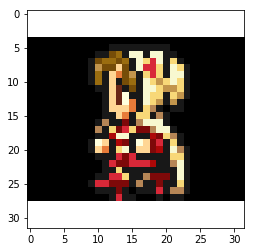

In [53]:
# Resize image from 96x96 to smaller dimension 32x32

IMG_SIZE = 32

def test_img_resize():
    img_path_to_resize = 'img/FFRK_Devout_sprites02.png'
    img_array = cv2.imread(img_path_to_resize, cv2.IMREAD_COLOR)
    # img_array = cv2.imread(os.path.join(path,file), cv2.IMREAD_COLOR)  # convert to array
    
    # convert back to original color
    img_array_RGB = cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB)

    new_array_resize = cv2.resize(img_array_RGB, (IMG_SIZE, IMG_SIZE))

    # plt.axis('off')
    plt.imshow(new_array_resize)
    plt.show()

test_img_resize()


In [57]:
# 2.5 resize all images to same dimension 32x32
# in img folder, from 96x96 to 32x32

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm

img_resized = []

def all_imgs_resize_in_memory(img_folder='img', img_resize=32, display=10):
    c = 0
    for file in tqdm_notebook(os.listdir(img_folder)):
        if not file.endswith('.png'):
            continue
            
        img_path_to_resize = os.path.join(img_folder, file)
        img_array = cv2.imread(img_path_to_resize, cv2.IMREAD_COLOR)

        # convert back to original color
        img_array_RGB = cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB)

        # resize
        new_array_resized = cv2.resize(img_array_RGB, (img_resize, img_resize))

        # add to list
        img_resized.append(new_array_resized)
        
        c+=1
        
        # display the first 10 images only
        if c < display+1:
            # plt.axis('off')
            plt.imshow(new_array_resized)    
            plt.show()  # display!
#         else:
#             break
    print ('Saved all resixed images in memory %s.' % ('img_resized'))

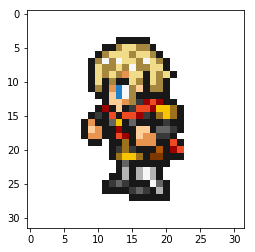

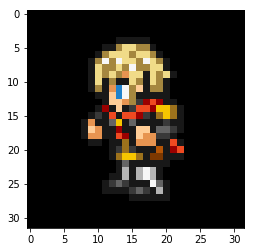

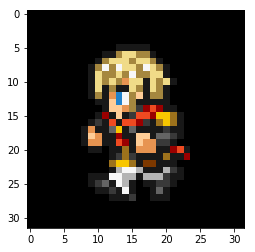

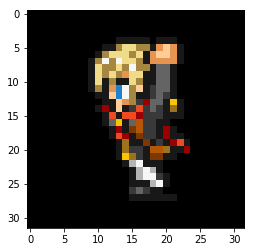

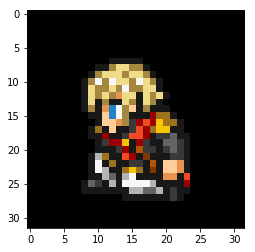

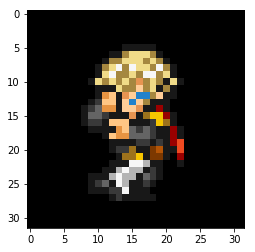

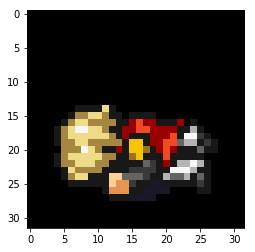

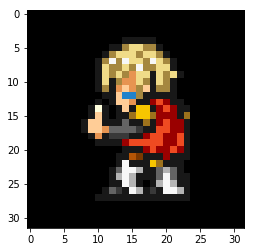

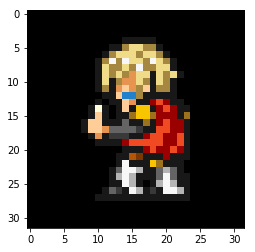

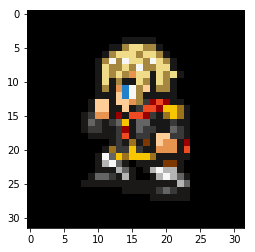

Saved all resixed images in memory img_resized.


In [58]:
# resize to 32x32, display first 10 only
all_imgs_resize_in_memory('img', 32, 10)

In [59]:
print (len(img_resized))

3838


In [60]:
# save all resized image list to a binary file
# so all above code do not need to re-run

import pickle

save_path = 'x_train.pickle'
pickle.dump(img_resized, open(save_path,"wb"))

In [61]:
######################################################################
# Part 3 - GAN 
# 3.1 load pre-processed images as x train set
# 3.2 implement the GAN model, code ref:
#     book deep learning with python
#     dlnd project 5 source code
# 3.3 after model is trained, generate some new images
######################################################################

In [62]:
# packages required
import matplotlib.pyplot as plt
import pickle
import numpy as np

In [63]:
# 3.1 load pre-processed images as x train set

# load data back from pickle
load_path = 'x_train.pickle'
x_train = pickle.load(open(load_path, "rb"))
print (len(x_train))

3838


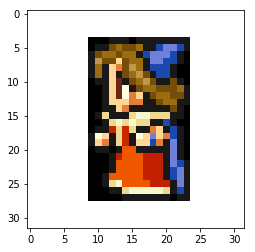

In [66]:
# test load any image from loaded x_train
import random

plt.imshow(random.choice(x_train))
plt.show()

In [67]:
type(x_train)

list

In [68]:
# 3.2 implement the GAN model

# Code from book - deep learning with python
# 8.5-introduction-to-gans.ipynb
# https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/8.5-introduction-to-gans.ipynb


In [69]:
# No change from original code

import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [70]:
import keras
from keras import layers
import numpy as np

# original parameters
# none

# tweak parameters
# none

# these parameters should be fixed
# as input and output images are 32x32, and 3 color channels
latent_dim = 32
height = 32
width = 32
channels = 3

#####################
# No change from here
#####################

generator_input = keras.Input(shape=(latent_dim,))

# First, transform the input into a 16x16 128-channels feature map
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

# Then, add a convolution layer
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Upsample to 32x32
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

# Few more conv layers
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Produce a 32x32 1-channel feature map
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       1048832   
__________

In [71]:
# No change from original code structure architect
# but change parameters

# original values
# strides = 2
# drop_out = 0.4
# generated images is bad, nothing like original

# tweaking parameter values
strides = 2
drop_out = 0.8 # better value to avoid overfitting
# generated images is recognisable

discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=strides)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=strides)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=strides)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

# One dropout layer - important trick!
x = layers.Dropout(drop_out)(x)

# Classification layer
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

# To stabilize training, we use learning rate decay
# and gradient clipping (by value) in the optimizer.

# original
# discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)

# to tweak later
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)

discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 6, 6, 128)         0         
__________

In [72]:
# No change from original code

# Set discriminator weights to non-trainable
# (will only apply to the `gan` model)
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

In [73]:
# changed from original code
import os
from keras.preprocessing import image

In [74]:
# Code for loading X, changed to use my own data
x_train = np.array(x_train)

x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

In [75]:
###########################################################
# Almost no change from here, except:
#   generated + real images filenames
#   put code into a method to re-train on saved gan weights
###########################################################

def train_model(gan, batch_size, iterations):

    if not os.path.exists('gan_images'):
        os.mkdir('gan_images')
    
    # save_dir = '/home/ubuntu/gan_images/' # book dir path
    save_dir = os.curdir + '/gan_images/'   # my dir path

    # Start training loop
    start = 0
    for step in range(iterations):
        # Sample random points in the latent space
        random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

        # Decode them to fake images
        generated_images = generator.predict(random_latent_vectors)

        # Combine them with real images
        stop = start + batch_size
        real_images = x_train[start: stop]
        combined_images = np.concatenate([generated_images, real_images])

        # Assemble labels discriminating real from fake images
        labels = np.concatenate([np.ones((batch_size, 1)),
                                 np.zeros((batch_size, 1))])
        # Add random noise to the labels - important trick!
        labels += 0.05 * np.random.random(labels.shape)

        # Train the discriminator
        d_loss = discriminator.train_on_batch(combined_images, labels)

        # sample random points in the latent space
        random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

        # Assemble labels that say "all real images"
        misleading_targets = np.zeros((batch_size, 1))

        # Train the generator (via the gan model,
        # where the discriminator weights are frozen)
        a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)

        start += batch_size
        if start > len(x_train) - batch_size:
          start = 0

        # Occasionally save / plot
        if step % 100 == 0:
            # Save model weights
            gan.save_weights('gan.h5')

            # Print metrics
            print('discriminator loss at step %s: %s' % (step, d_loss))
            print('adversarial loss at step %s: %s' % (step, a_loss))

            # Save one generated image
            img = image.array_to_img(generated_images[0] * 255., scale=False)
            img.save(os.path.join(save_dir, 'generated_sprite' + str(step) + '.png'))

            # Save one real image, for comparison
            img = image.array_to_img(real_images[0] * 255., scale=False)
            img.save(os.path.join(save_dir, 'real_sprite' + str(step) + '.png'))

In [81]:
# gan model load weights
# comment out the follow lines of code if training model from the beginning, 
# with no saved weights

if os.path.exists('saved_gan.h5'):
    gan.load_weights('saved_gan.h5')
    print ('Saved weights is loaded back to the model.')
else:
    print ('No saved weights found.')

Saved weights is loaded back to the model.


In [82]:
# hyper parameters
# original settings
# iterations = 10000
# batch_size = 20

# tweak parameters
# iterations = 10000
# batch_size = 50
# fair result, face and body shape do look like original images, but too much noise

# iterations = 10000
# batch_size = 200 # ResourceExhaustedError

iterations = 10000
batch_size = 100 # generated acceptable result

train_model(gan, batch_size, iterations)

# rename saved gan file from 'gan.h5' to 'saved_gan.h5'
# to avoid overwritten by model training code if re-run
import os
os.rename('gan.h5', 'saved_gan.h5')


discriminator loss at step 0: 0.16278765
adversarial loss at step 0: 8.829107


In [83]:
# save and load generator, so no need to re-train model to generate new images 

# save generator
pickle.dump(generator, open('generator.pickle',"wb"))

In [84]:
# load generator
load_generator = pickle.load(open('generator.pickle',"rb"))

/home/fi/anaconda3/envs/sentdex/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [85]:
# 3.3 after model is trained, generate some new images
import matplotlib.pyplot as plt

def generate_and_show_images(gen, count):
    # Sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(count, latent_dim))

    # Decode them to fake images
    generated_images = gen.predict(random_latent_vectors)

    for i in range(generated_images.shape[0]):
        img = image.array_to_img(generated_images[i] * 255., scale=False)
        plt.figure()
        plt.imshow(img)

    plt.show()
    

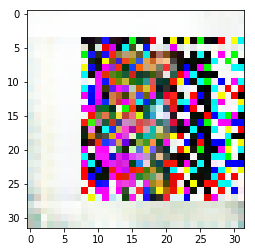

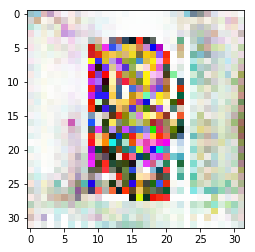

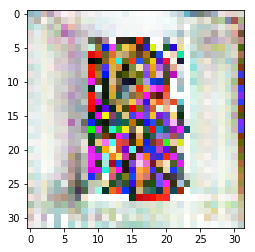

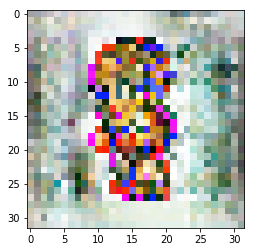

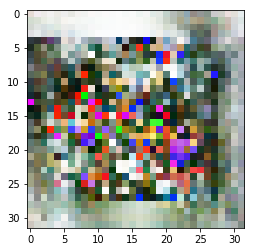

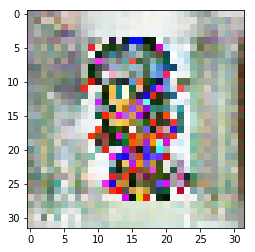

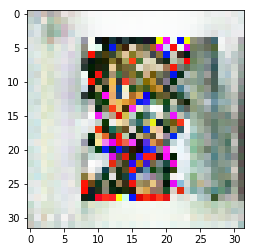

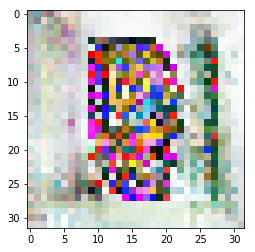

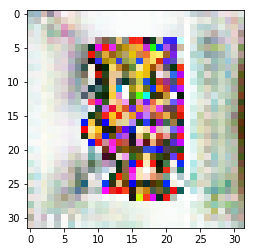

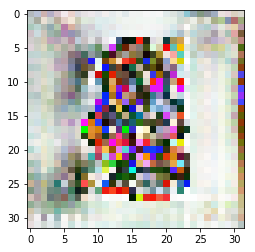

In [91]:
generate_and_show_images(load_generator, 10)

In [92]:
# display best generated images in a grid

import cv2
from tqdm import tnrange, tqdm_notebook

def show_best_generated_imgs(img_folder='best_gen_result'):

    # 1.load images to list
    img_list = []
    
    for file in tqdm_notebook(os.listdir(img_folder)):
        if not file.endswith('.png'):
            continue
            
        img_path = os.path.join(img_folder, file)
        img_array = cv2.imread(img_path, cv2.IMREAD_COLOR)

        # convert back to original color
        img_array_RGB = cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB)

        # add to list
        img_list.append(img_array_RGB)
                
    # 2.display images in a grid
    # copy and pasted from web
    fig=plt.figure(figsize=(12, 12))
    columns = 4
    rows = 5
    for i in range(1, columns*rows +1):
        img = img_list[i]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
    plt.show()


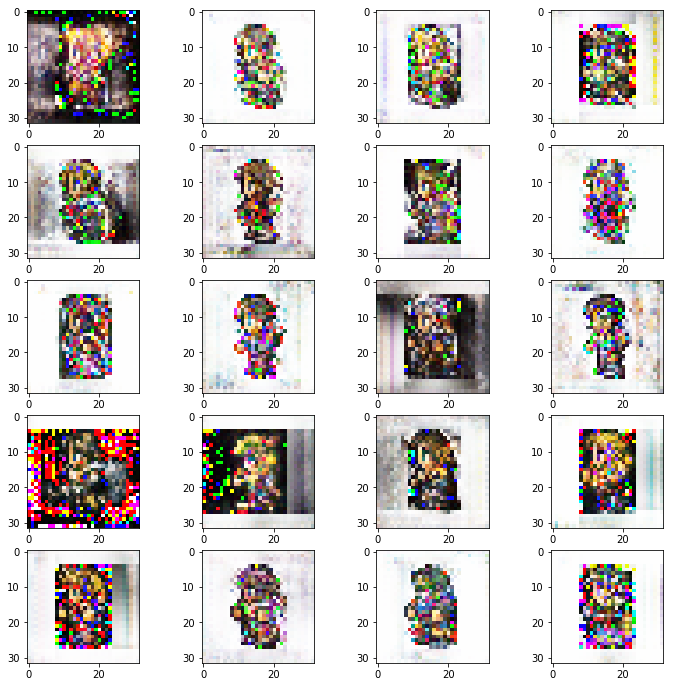

In [93]:
show_best_generated_imgs()

In [ ]:
##########################################################
# Result analysis on generated images in gan_images folder
##########################################################
# train 001 result is rubbish, images mostly a blob of pixels

# train 005 result is much better, training took about 7 hours for 10000 iterations
# with
#   training data - blank images removed
#   training data - mini characters images removed
#   parameter - larger batch size
#   parameter - larger dropout

# The result is not great, the generated images have lot of noise, but recognisable.

In [ ]:
###########################################################
# Ways to improve model training - notes on thu 03 jan 2018
###########################################################
# Data quantity + quality
#   get more ff6 sprite images from websites
#     currently model is training on 3800+ images, 
#     ideally should be 30k images, like some DCGAN examples
#   filter images
#     the character dead pose might not be suitable for training, 
#     could be remove by code
#   cropped images background
#     the bg is cropped on 1st and last image on each row, 
#     the pixels is best fitted on left and right of spritesheet
#     this messes up the train data, and some cropped image bg is stripped with white and black vertically
# GPU upgrade
#   currently using 2015 GTX 960M 2GB, benchmark score is 2279
#   consider 2018 RTX 2070 8GB with Tensor Core, benchmark score is 14383
#     with 16 bit training to double VRam, which allow larger batch size
# Hyper parameters tweaking
#   currently training time is too slow to tweak parameters without waiting a long time  
#   try changing dropout, batch size, learning rate, iterations
#   and latent_dim?
# Architecture
#   add more layers in generator, as the discriminator lost is much smaller 
#   use different lost function and optimizer
#
#   try balance between generator lost and discriminator lost
# result were like the following:
# discriminator loss at step 9700: -0.019410443
# adversarial loss at step 9700: 12.436728
# discriminator loss at step 9800: -0.033391457
# adversarial loss at step 9800: 12.792533
# discriminator loss at step 9900: 0.19051735
# adversarial loss at step 9900: 15.333755

In [ ]:
##############
# Bibliography
##############

####################
# main code tutorial

# Getting all company pricing data in the S&P 500 - Python Programming for Finance p.6
# https://pythonprogramming.net/sp500-company-price-data-python-programming-for-finance/?completed=/sp500-company-list-python-programming-for-finance/
# beautiful soup - html parser, requests - web get files, pickle - dump file
    
# Loading in your own data - Deep Learning basics with Python, TensorFlow and Keras p.2
# https://pythonprogramming.net/loading-custom-data-deep-learning-python-tensorflow-keras/?completed=/introduction-deep-learning-python-tensorflow-keras/
# opencv - image load, view, re-color, resize, copy

# Introduction to generative adversarial networks
# https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/8.5-introduction-to-gans.ipynb
# DCGAN - basic model

##########
# snippets

# Find all files in a directory with extension .txt in Python
# https://stackoverflow.com/questions/3964681/find-all-files-in-a-directory-with-extension-txt-in-python
# import os
# for file in os.listdir("/mydir"):
#     if file.endswith(".txt"):
        
# Get filename from file pointer [duplicate]
# https://stackoverflow.com/questions/15225557/get-filename-from-file-pointer
# import os
# f = open('foo/bar.txt')
# os.path.basename(f.name)

# 10.1. os.path — Common pathname manipulations
# https://docs.python.org/2/library/os.path.html
# os.path.basename(path)
    
# Python equivalent of a given wget command
# https://stackoverflow.com/questions/24346872/python-equivalent-of-a-given-wget-command
    
# Each iteration of progressbar starts a new line in Jupyter #375 
# https://github.com/tqdm/tqdm/issues/375
# from tqdm import tnrange, tqdm_notebook
    
# Open CV Getting Started with Images
# https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_gui/py_image_display/py_image_display.html    
# cv2.IMREAD_COLOR
    
# OpenCV giving wrong color to colored images on loading
# https://stackoverflow.com/questions/39316447/opencv-giving-wrong-color-to-colored-images-on-loading
# RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    
# ImportError: No module named PIL
# https://stackoverflow.com/questions/8863917/importerror-no-module-named-pil
# pip install Pillow

# How to Split Image Into Multiple Pieces in Python
# https://stackoverflow.com/questions/5953373/how-to-split-image-into-multiple-pieces-in-python
# box = (j, i, j+width, i+height)
# a = im.crop(box)
    
# Batch Renaming of Files in a Directory
# https://stackoverflow.com/questions/225735/batch-renaming-of-files-in-a-directory
# os.rename(pathAndFilename, os.path.join(dir, titlePattern % title + ext))

# How do I copy a file in Python?
# https://stackoverflow.com/questions/123198/how-do-i-copy-a-file-in-python
# from shutil import copyfile
# copyfile(src, dst)

# Python PIL Detect if an image is completely black or white
# https://stackoverflow.com/questions/14041562/python-pil-detect-if-an-image-is-completely-black-or-white
# if not img.getbbox():
# if not ImageChops.invert(img).getbbox():

# importing python modules - ImageChops
# https://stackoverflow.com/questions/19341500/importing-python-modules-imagechops
# from PIL import ImageChops

# Python Delete File
# https://www.w3schools.com/python/python_file_remove.asp
# import os
# os.remove("demofile.txt") 

# Count total number of white pixels in an image is throwing an error
# https://stackoverflow.com/questions/47494350/count-total-number-of-white-pixels-in-an-image-is-throwing-an-error
# img = cv2.imread('img.png', cv2.IMREAD_GRAYSCALE)
# n_white_pix = np.sum(img == 255)

# How to randomly select an item from a list?
# https://stackoverflow.com/questions/306400/how-to-randomly-select-an-item-from-a-list
# random.choice(foo)

# Save and load weights in keras
# https://stackoverflow.com/questions/47266383/save-and-load-weights-in-keras
# model.save_weights('my_model_weights.h5')
# model.load_weights('my_model_weights.h5')

# How to rename a file using Python
# https://stackoverflow.com/questions/2491222/how-to-rename-a-file-using-python
# os.rename('a.txt', 'b.kml')

# How to display multiple images in one figure correctly? [duplicate]
# https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure-correctly/46616645
# code snippet used above in notebook

##############
# links to try

# Is there a way to “lock” some cells in a notebook?
# https://mathematica.stackexchange.com/questions/13939/is-there-a-way-to-lock-some-cells-in-a-notebook

# Jupyter notebook: protect cells #2641 
# https://github.com/sagemathinc/cocalc/issues/2641
    
# Extracting extension from filename in Python
# https://stackoverflow.com/questions/541390/extracting-extension-from-filename-in-python
# filename, file_extension = os.path.splitext('/path/to/somefile.ext')
    
# Trim whitespace using PIL
# https://stackoverflow.com/questions/10615901/trim-whitespace-using-pil
  
# Unnecessary Warning for trainable parameters #8585
# https://github.com/keras-team/keras/issues/8585
# A warning bug on model training
    
    